# Construyendo una red neuronal con Keras

## ¿Qué librerías necesitamos?

In [20]:
import numpy
import tensorflow as tf

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers, regularizers

### Otras librerías

In [21]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

## Cargando los datos del MNIST

- El conjunto de datos a utilizar es el **[MNIST](http://yann.lecun.com/exdb/mnist/)**.
- Es un conjunto estándar para hacer *reconocimiento de imágenes*.
- Buscamos entrenar un clasificador que reconozca que dígito es mostrado en la imagen.
- El MNIST está compuesto por imágenes de 28x28 píxeles representadas como matrices.
- La salida son 10 clases (dígitos del 0 al 9).
- Se preprocesará para *convertir las matrices en vectores* y transformar las etiquetas en representaciones *one-of-k*.

In [22]:
batch_size = 128  # For mini-batch gradient descent
num_classes = 10
epochs = 10
input_size = 28*28
train_examples = 60000
test_examples = 10000

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# reshape the dataset to convert the examples from 2D matrixes to 1D arrays.
x_train = x_train.reshape(train_examples, input_size)
x_test = x_test.reshape(test_examples, input_size)

# normalize the input
x_train = x_train / 255
x_test = x_test / 255

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

## Contruyendo la red neuronal

- Comenzaremos por construir un *perceptrón multicapa* que es la red neuronal más común.
- El modelo más simple en Keras es una concatenación de capas (layers).
    - Se llama modelo secuencial.
- La capa más básica es la *densa* (dense o fully connected).
    - Internamente tiene dos variables: una matriz de pesos y un vector de biases. Keras nos abstrae de todo eso.

In [23]:
model = Sequential()

# Input to hidden layer
model.add(Dense(512, input_shape=(input_size,)))
model.add(Activation('relu'))

# Hidden to output layer
model.add(Dense(10))
model.add(Activation('softmax'))

Para imprimir una descripción del modelo existe un comando:

In [24]:
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 512)               401920    
_________________________________________________________________
activation_4 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 10)                5130      
_________________________________________________________________
activation_5 (Activation)    (None, 10)                0         
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________
None


# Hiperparámetros

## Funciones de Activación

- Una red neuronal con activación lineal no tiene mucho más poder de representación que un algoritmo lineal.
- Para expresar no linearidad en la red neuronal se necesitan funciones no lineales de activación.
- Una función de activación común es la *sigmoide* (o logística).
- Keras soporta varias funciones de activación: rectified linea unit (ReLU), tangenge hiperbólica, sigmoide "dura", etc.
    - Hoy en día, por sus propiedades, ReLU suele ser la más utilizada [1].
- La función de activación *softmax* es utilizada al final de la red y sirve para clasificación.

![Funciones de activación](images/activation_functions.png "Funciones de activación")
<div style="text-align: right;">Fuente: https://ujjwalkarn.me/2016/08/09/quick-intro-neural-networks/</div>

In [25]:
model = Sequential([
    Dense(64, input_shape=(784,), activation='relu'),
    Dense(32, activation='relu'),
    Dense(10, activation='softmax')
])

print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_17 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_18 (Dense)             (None, 10)                330       
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
_________________________________________________________________
None


## Regularización de la red

### Regularización de los pesos

- La red puede regularizarse penalizando los pesos.
- Los pesos se regularizan mediante alguna norma:
    - L1 es la suma del valor absoluto: ${\displaystyle \lambda \sum_{i=1}^{k} |w_i|}$
    - L2 es la suma del valor cuadrado, es la más común: ${\displaystyle \lambda \sum_{i=1}^{k} w_i^2}$
    - Elastic net es una combinación de ambas: ${\displaystyle \lambda_1 \sum_{i=1}^{k} |w_i| + \lambda_2 \sum_{i=1}^{k} w_i^2}$
- Para un análisis detallado de la diferencia entre L1 y L2 revisar [\[2\]](http://www.chioka.in/differences-between-l1-and-l2-as-loss-function-and-regularization/)

In [26]:
model = Sequential([
    Dense(64, input_shape=(784,), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.01))
])

### Dropout

- Otra forma muy usada a la hora de regularizar es el **dropout** [3].
- Es extremadamente efectivo y simple.
- Es complementario a L1/L2/ElasticNet.
- Durante el entrenamiento se implementa apagando un neurón con alguna probabilidad **_p_** (un hiperparámetro).

![Dropout](images/dropout.jpeg "Dropout")
<div style="text-align: right;">Fuente: Trabajo de Srivastava et al. [3]</div>

### Dropout en Keras

- Se aplica agregando capas al modelo.
- Se llaman capas `Dropout` y se agrega a cada capa que se quiere regularizar.

In [27]:
model = Sequential([
    Dense(64, input_shape=(784,), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

### Batch Normalization

- En general, para acelerar la convergencia de la red, se normalizan los features de entrada, de manera que todos estén en un rango similar.
- Esta idea también puede llevarse a las capas ocultas de la red.
- La idea de la "Normalización por Lotes" (*Batch Normalization*) [4] es reducir el rango en el que se mueven los valores de las neuronas ocultas.
- La manera en que se hace esto es restarle, a cada salida de cada capa oculta, la media del lote (batch) de datos de entrenamiento y dividirlo por la desviación estándar (a grandes razgos).
- Como resultado, la red converge más rápido e incluso se genera un efecto de regularización.

### BatchNormalization en Keras.

- Se aplica agregando capas al modelo.
- Se llaman capas `BatchNormalization` y se agrega a cada capa que se quiere normalizar.
- El `momentum` es un parámetro que decide cuánta información de los lotes anteriores se tiene en cuenta a la hora de normalizar el lote actual (en el trabajo original, este es de `0`).

In [28]:
model = Sequential([
    Dense(64, input_shape=(784,), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(momentum=0),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

## Preparando el modelo para entrenarlo

- Para minimizar una red neuronal necesitamos *calcular sus gradientes*.
    - Esto se hace con el algoritmo de *retropropagación*.
- Keras tiene la capacidad de hacerlo automáticamente.
    - Esto se conoce como _diferenciación automática_ y es algo común en los frameworks de deep learning.
- El modelo de Keras necesita *compilarse*.
    - Recordar que lo que armamos en Keras (o TensorFlow) es un grafo de computación.
- Al compilar el modelo los parámetros más importantes son la función de costo y el algoritmo de optimización.

### Funciones de costo y algoritmos de optimización

- La función de costo puede cambiar de acuerdo al tipo de problema (clasificación binaria/multiclase o regresión).
    - La funciones más comunes son la media del error cuadrático (_mean squared error_) para regresión y la entropía cruzada (_crossentropy_) para clasificación.
- El algoritmo de optimización es el que entrena la red. Existen varios, que en si son variaciones del algoritmo de _descenso por la gradiente_.

<div style="text-align: center; margin: 5px 0;">
    <div style="display: inline-block;">
        <img src="images/contours_evaluation_optimizers.gif" alt="Optimización" style="width: 350px;"/>
    </div>
    <div style="display: inline-block;">
        <img src="images/saddle_point_evaluation_optimizers.gif" alt="Optimización" style="width: 350px;"/>
    </div>
</div>
<div style="text-align: right;">Fuente: http://ruder.io/optimizing-gradient-descent/</div>

### Compilando el modelo Keras y visualizando la arquitectura

- Con el método `.compile()` podemos compilar el modelo de Keras.
- Además de la función de costo y el algoritmo de optimización se le pueden pasar métricas para llevar registro además del error de los datos (e.g. la exactitud o la precisión).
- Una vez compilado el modelo la modificación requerirá rehacerlo desde cero (salvo que se guarden y carguen los pesos).

In [29]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-4),
                  # También podría ser el string "Adagrad" con los parámetros por defecto
              metrics=['accuracy'])  # La métrica sirve para llevar algún registro además del costo

##### una vez que compilamos el modelo no podemos modificar la arquitectura

### Visualizar la arquitectura (opcional)

Opcionalmente, si instalamos las librerías extras pedidas en el setup y utilizando `vis_util`, podemos visualizar el grafo de la red.

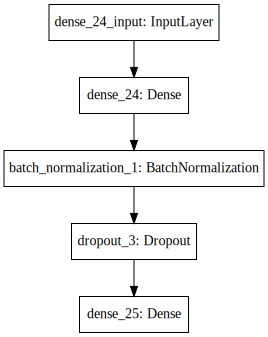

In [30]:
SVG(model_to_dot(model, dpi=72).create(prog='dot', format='svg'))

## Entrenamiento

- Una vez compilado el modelo, está listo para ser entrenado.
- Keras tiene una interfaz similar a Scikit-Learn, con lo método `fit` y `predict`.
- Para entrenar se necesitan 3 parámetros:
    - El conjunto de datos de entrenamiento (datos y etiquetas).
    - El tamaño del batch para hacer _mini-batch gradient descent_.
    - La cantidad de épocas que entrenar.
    - Eventualmente le podemos pasar datos para hacer validación del modelo.
    - El parámetro `verbose` nos imprime información útil respecto al desempeño del modelo.

#### notas: muy parecido a scikit learn, la cantidad para entrenar por defecto es uno, validation data se da como una tupla de valores, verbose viene por defecto en 1, si pusiera history= model.fit ...etc entonces me mostraria 

In [31]:
model.fit(x_train, y_train, 
          batch_size=batch_size, epochs=epochs, 
          validation_data=(x_test, y_test), verbose=1);

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 24s 400us/sample - loss: 2.3641 - accuracy: 0.5511 - val_loss: 1.2733 - val_accuracy: 0.8579
Epoch 2/10
60000/60000 [==============================] - 6s 92us/sample - loss: 1.3131 - accuracy: 0.7952 - val_loss: 0.9294 - val_accuracy: 0.9036
Epoch 3/10
60000/60000 [==============================] - 5s 91us/sample - loss: 1.0353 - accuracy: 0.8419 - val_loss: 0.7646 - val_accuracy: 0.9158
Epoch 4/10
60000/60000 [==============================] - 4s 68us/sample - loss: 0.8711 - accuracy: 0.8649 - val_loss: 0.6648 - val_accuracy: 0.9180
Epoch 5/10
60000/60000 [==============================] - 3s 57us/sample - loss: 0.7562 - accuracy: 0.8779 - val_loss: 0.5759 - val_accuracy: 0.9243
Epoch 6/10
60000/60000 [==============================] - 7s 118us/sample - loss: 0.6650 - accuracy: 0.8901 - val_loss: 0.4975 - val_accuracy: 0.9319
Epoch 7/10
60000/60000 [=============================

In [ ]:
history= model.fit(x_train, y_train, 
          batch_size=batch_size, epochs=epochs, 
          validation_data=(x_test, y_test), verbose=1);

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 64us/sample - loss: 0.4245 - accuracy: 0.9151 - val_loss: 0.3046 - val_accuracy: 0.9444
Epoch 2/10
60000/60000 [==============================] - 4s 62us/sample - loss: 0.3992 - accuracy: 0.9181 - val_loss: 0.2849 - val_accuracy: 0.9474
Epoch 3/10
60000/60000 [==============================] - 4s 62us/sample - loss: 0.3721 - accuracy: 0.9225 - val_loss: 0.2707 - val_accuracy: 0.9500
Epoch 4/10
60000/60000 [==============================] - 4s 62us/sample - loss: 0.3532 - accuracy: 0.9252 - val_loss: 0.2531 - val_accuracy: 0.9518
Epoch 5/10
60000/60000 [==============================] - 4s 63us/sample - loss: 0.3384 - accuracy: 0.9258 - val_loss: 0.2329 - val_accuracy: 0.9539
Epoch 6/10
60000/60000 [==============================] - 4s 62us/sample - loss: 0.3272 - accuracy: 0.9280 - val_loss: 0.2334 - val_accuracy: 0.9531
Epoch 7/10
60000/60000 [==============================] 

In [19]:
import pandas as pd
pd.DataFrame(history.history)

NameError: name 'history' is not defined

## Referencias

- [1] LeCun, Yann, Bengio, Yoshua, and Hinton, Geoffrey. "Deep learning." Nature 521, no. 7553 (2015): 436-444.
- [2] "Differences between L1 and L2 as Loss Function and Regularization". http://www.chioka.in/differences-between-l1-and-l2-as-loss-function-and-regularization/
- [3] Srivastava, Nitish, Geoffrey E. Hinton, Alex Krizhevsky, Ilya Sutskever, and Ruslan Salakhutdinov. "Dropout: a simple way to prevent neural networks from overfitting." Journal of machine learning research 15, no. 1 (2014): 1929-1958. Harvard.
- [4] Ioffe, S., & Szegedy, C. (2015). Batch normalization: Accelerating deep network training by reducing internal covariate shift. arXiv preprint arXiv:1502.03167.